In [85]:
%matplotlib inline

In [86]:
import numpy as np
import datetime as dt
import time as t
import matplotlib.pyplot as plt
import pandas as pd
import pycountry as pc
import plotly.express as px
import us

# Shark Attack Data Analysis


For this purpose, we will use a dataset that contains reported shark attacks on humans over the last 100 years.

In [87]:
attacks = pd.read_csv("./data/attacks.csv")

The dataset is verry messy and will be difficult to work with. Even when reading the data, it is noticed that most of the observations are **empty**.


In [88]:
attacks_count = attacks.shape[0]
not_empty_observations = len(attacks.dropna(how='all'))
empty_observations = attacks_count - not_empty_observations

print(
f"""\
Dataframe count: {attacks_count},
Not empty: observations: {not_empty_observations},
Empty observations: {empty_observations}\
""")

Dataframe count: 25614,
Not empty: observations: 6096,
Empty observations: 19518


As we see in the example above, approximately **76%** of our data is invalid. This would not be a big problem in the analysis, because we can skip the empty observations, but in order to improve the performance, it is better to keep the data we will work with. For this purpose, we will overwrite the dataset as follows:

In [89]:
attacks = attacks.dropna(how='all')

As already mentioned, it is good to keep **only the data we will work with**, so we will take only those features that we need and rename them in a conventional way.

In [90]:
attacks = attacks[['Date', 'Type', 'Country', 'Area', 'Activity', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)']]
attacks.columns = ['date', 'type', 'country', 'area', 'activity', 'sex', 'age', 'injury', 'fatal']

print(attacks.dtypes)

date        object
type        object
country     object
area        object
activity    object
sex         object
age         object
injury      object
fatal       object
dtype: object


We have successfully extracted and renamed only the necessary features, but as you can see they are not the right data type at all. Let's start with **date**:

Many of the observations in the date column have invalid dates, but there are also valid ones with the string **Reported** before the date itself, which we can remove.

In [91]:
date_with_reported_count = len(attacks[attacks['date'].str.contains("Reported", na=False)])

print(f"Dates with \'Reported\' count: {date_with_reported_count}")

Dates with 'Reported' count: 513


In [92]:
def transform_date(date):
    if isinstance(date, str) and 'Reported' in date:
        date = date[9:]
    
    return date

We will use the function on top to transorm the date feature.

In [93]:
attacks['date'] = attacks['date'].apply(transform_date)

We must also convert the **fatal** fetature.

In [94]:
def transform_fatal(fatal):
    if isinstance(fatal, str) and fatal.lower() == 'y':
        return 'Yes'
    elif isinstance(fatal, str) and fatal.lower() == 'n':
        return 'No'
    else:
        return 'Invalid'

In [95]:
attacks['fatal'] = attacks['fatal'].apply(transform_fatal)

Now convert each feature to the appropriate type for it.

In [96]:
attacks['date'] = pd.to_datetime(attacks['date'], errors='coerce')
attacks['type'] = pd.Categorical(attacks['type'])
attacks['country'] = pd.Categorical(attacks['country'])
attacks['area'] = pd.Categorical(attacks['area'])
attacks['activity'] = pd.Categorical(attacks['activity'])
attacks['age'] = pd.to_numeric(attacks['age'], errors='coerce').fillna(0).astype('Int64')
attacks['sex'] = pd.Categorical(attacks['sex'])
attacks['injury'] = pd.Categorical(attacks['injury'])
attacks['fatal'] = pd.Categorical(attacks['fatal'])

print(attacks.dtypes)

date        datetime64[ns]
type              category
country           category
area              category
activity          category
sex               category
age                  Int64
injury            category
fatal             category
dtype: object


All the data seems to be of the correct type and we can start with the analysis. Let's visualize shark attacks on a world map. For this purpose we will have to convert all the state in all observations in iso format.

In [97]:
country_counts_dict = {}
for country, count in attacks['country'].dropna().value_counts().items():
    try:
        iso = pc.countries.search_fuzzy(country)[0].alpha_3
        country_counts_dict[iso] = [count]
    except:
        continue

country_counts = pd.DataFrame(country_counts_dict).T.reset_index()
country_counts.columns = ['country', 'attacks_count']


In [98]:
world = px.choropleth(country_counts,
                    locations="country",
                    color="attacks_count",
                    hover_name='country',
                    title="Shark attacks count by country",
                    color_continuous_scale=px.colors.sequential.Reds)
world.show()

In [99]:
top_three_attacked = attacks[attacks['country'].isin(['USA', 'AUSTRALIA', 'SOUTH AFRICA']) & (attacks['date'].dt.year <= 2021)].dropna().reset_index()

Тhe map clearly shows which countries have the most registered cases of shark attacks. Let's check how the attacks have changed over the years.

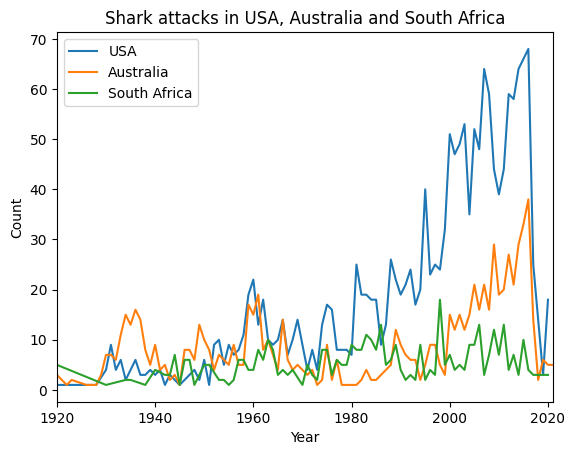

In [100]:
plt.plot(top_three_attacked[top_three_attacked['country'] == 'USA'].groupby(top_three_attacked['date'].dt.year).\
         size(), label = 'USA')

plt.plot(top_three_attacked[top_three_attacked['country'] == 'AUSTRALIA'].groupby(top_three_attacked['date'].dt.year).\
         size(), label = 'Australia')

plt.plot(top_three_attacked[top_three_attacked['country'] == 'SOUTH AFRICA'].groupby(top_three_attacked['date'].dt.year).\
         size(), label = 'South Africa')

plt.xlim(left=1920, right=2021)
plt.ylabel('Count')
plt.xlabel('Year')
plt.title("Shark attacks in USA, Australia and South Africa")
plt.legend()
plt.show()

The graph shows that around 2020 there is a big drop in shark attacks. Perhaps the reason is the limitations of Covid 19.

We see that the **USA** is in the first place in terms of shark attacks. Let's take a closer look at which areas this happens more often.

In [101]:
mask_usa_area = (attacks['country'] == 'USA') & (attacks['area'] != None)
usa_data = attacks[mask_usa_area]

usa_area_counts = {}
for area, count in usa_data['area'].value_counts().items():
    try:
        abbr = us.states.lookup(area).abbr
        usa_area_counts[abbr] = [count]
    except:
        continue

usa_area_counts = pd.DataFrame(usa_area_counts).T.reset_index()
usa_area_counts.columns = ['area', 'attacks_count']

In [102]:
usa = px.choropleth(usa_area_counts,
                    locations=usa_area_counts['area'],
                    locationmode='USA-states',
                    color="attacks_count",
                    hover_name='area',
                    scope="usa",
                    title="USA shark attacks count by area",
                    color_continuous_scale=px.colors.sequential.Reds)
usa.show()

Florida has the most reported shark attacks in 100 years, but let's see how they've changed over the years. We will only use records for which there is a date.

<ipython-input-75-9e2035bd1b51>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



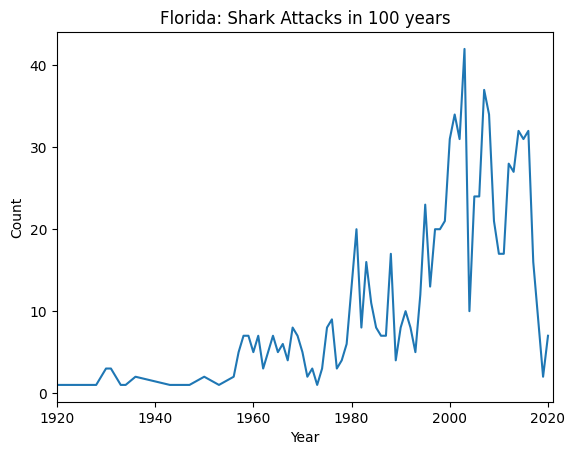

In [75]:
florida_data = usa_data[mask_usa_area & (usa_data['area'] == 'Florida') & (usa_data['date'].dt.year <= 2021)].dropna().reset_index()
florida_attacks_over_years = florida_data.groupby(florida_data['date'].dt.year).size()

plt.plot(florida_data.groupby(florida_data['date'].dt.year).size())
plt.xlim(left=1920, right=2021)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Florida: Shark Attacks in 100 years")
plt.show()

As we can see, the distribution of the graph is very similar to the graph above, which shows the attacks for the whole country, this is because most cases of attacks took place in Florida.

We have already seen that America (specifically Florida) has the most shark attacks. Let's take a closer look at what activity the shark attacked, but **let's work with all the data** because when we work with more data the results are more reliable.

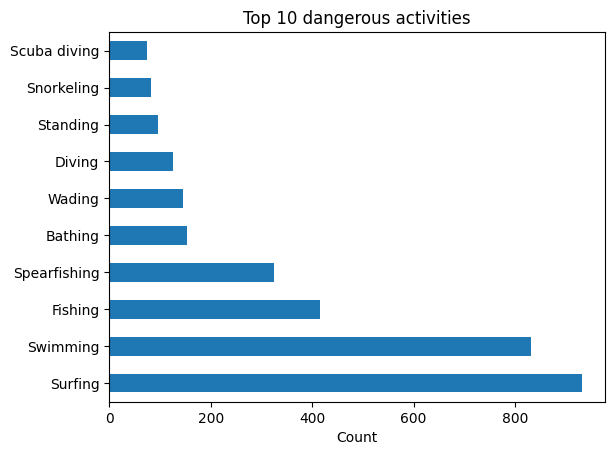

In [19]:
mask_activity = attacks['activity'] != None
activities_top_ten = attacks[mask_activity]['activity'].value_counts().nlargest(10)

activities_top_ten.plot.barh()
plt.xlabel("Count")
plt.title("Top 10 dangerous activities")
plt.show()

It is clear that of all these activities, **surfing** is the most dangerous, and this is to be expected. 
Let's see now how many cases have been **fatal**

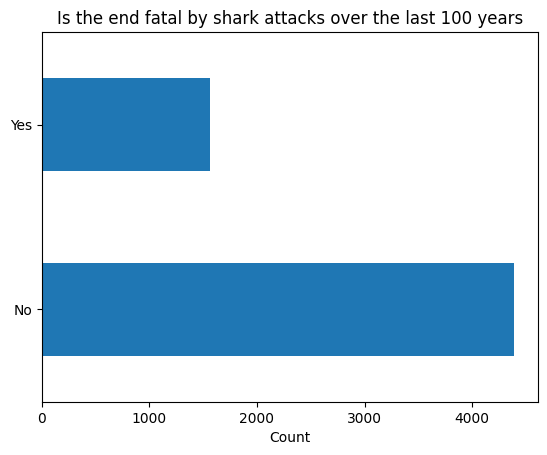

In [26]:
fatal_mask = attacks['fatal'] != 'Invalid'
fatal = attacks[fatal_mask]['fatal'].value_counts().drop(labels=['Invalid'])

fatal.plot.barh()
plt.xlabel("Count")
plt.title("Is the end fatal by shark attacks over the last 100 years")
plt.show()

It can be seen that a shark attack is more likely to survive, but it is likely to have serious consequences for survivors. We can check the **top 10 injuries of survivors** after a shark attack.

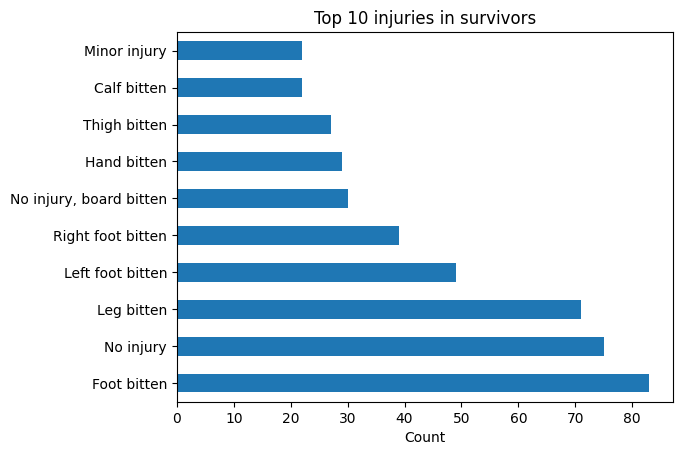

In [36]:
injuries = attacks[fatal_mask & (attacks['fatal'] == 'No') & (attacks['injury'] != 'Survived')]['injury'].\
value_counts().nlargest(10)

injuries.plot.barh()
plt.xlabel('Count')
plt.title('Top 10 injuries in survivors')
plt.show()